In [22]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from skimage.measure import compare_ssim, compare_psnr
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [23]:
import torch
import torch.utils.data as torch_data

from common.subsample import RandomMaskFunc

In [24]:
def compare_imgs(img_true, img_rec, verbose=True):

    assert img_true.shape == img_rec.shape
    if len(img_true.shape) == 3:
        assert img_true.shape[0] == 1

        img_true = img_true[0]
        img_rec = img_rec[0]

    img_true = img_true.numpy() if isinstance(img_true, torch.Tensor) else img_true
    img_rec = img_rec.numpy() if isinstance(img_rec, torch.Tensor) else img_rec

    mae = mean_absolute_error(img_true, img_rec)
    psnr = compare_psnr(img_true, img_rec)
    ssim = compare_ssim(img_true, img_rec)

    if verbose:
        print('\tMAE\tPSNR\tSSIM')
        print(f'score\t{mae:.3f}\t{psnr:.3f}\t{ssim:.3f}')

    return [mae, psnr, ssim]


def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)


def scale_MRI(image, low=2, high=98):

    lp, hp = np.percentile(image, (low, high))
    image_scaled = np.clip(image, lp, hp)

    image_scaled -= image_scaled.min()
    image_scaled /= image_scaled.max()
    image_scaled = image_scaled.astype(np.float32)

    return image_scaled


def scale_data(samples, path_to_save, threshold=5e-2):
    for s in tqdm(samples):
        data = npy_load(s)
        data = scale_MRI(data)
        data = data[np.newaxis, :, :]
        data[np.where(data < threshold)] = 0

        name = os.path.split(s)[1]

        with open(os.path.join(path_to_save, name), 'wb') as f:
            np.save(f, data)

## Load data

In [25]:
PATH_TO_DATA = 'ax_t2_single_scaled_v2/'
RANDOM_STATE = 42

## Data Loaders

In [26]:
class MRIDataSampler(torch_data.Dataset):
    def __init__(self, path_to_data, center_fractions, accelerations, 
                       shape=(1, 320, 320), seed=None, threshold=1e-7):
        super().__init__()
        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('npy')]
        self.images = sorted(self.images)

        self._mask_function = RandomMaskFunc(center_fractions=[center_fractions], 
                                             accelerations=[accelerations],
                                             seed=seed
                                            )
        self.mask = self._mask_function(shape, seed=seed).flatten().astype(bool)
        self.threshold = threshold

    def __len__(self):
        return len(self.images)

    def sample_slice(self, slice):
        slice_fft = np.fft.fft2(slice)
        slice_kspace = np.fft.fftshift(slice_fft)

        slice_kspace[:, :, ~self.mask] = 0

        slice_fft = np.fft.ifftshift(slice_kspace)
        sampled_image = np.fft.ifft2(slice_fft)

        sampled_image_abs = np.abs(sampled_image)
        sampled_image_abs -= sampled_image_abs.min()
        sampled_image_abs /= sampled_image_abs.max()

        sampled_image_abs[np.where(sampled_image_abs < self.threshold)] = 0

        return sampled_image_abs

    def __getitem__(self, idx):

        slice = npy_load(self.images[idx])
        slice_sampled = self.sample_slice(slice)

        return self.images[idx], slice, slice_sampled

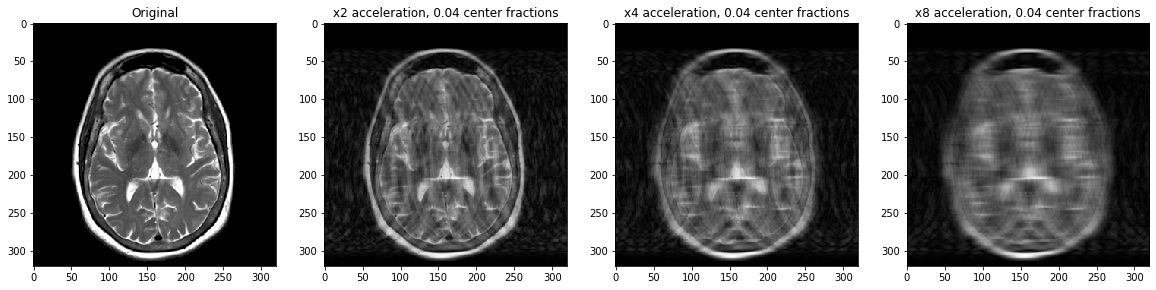

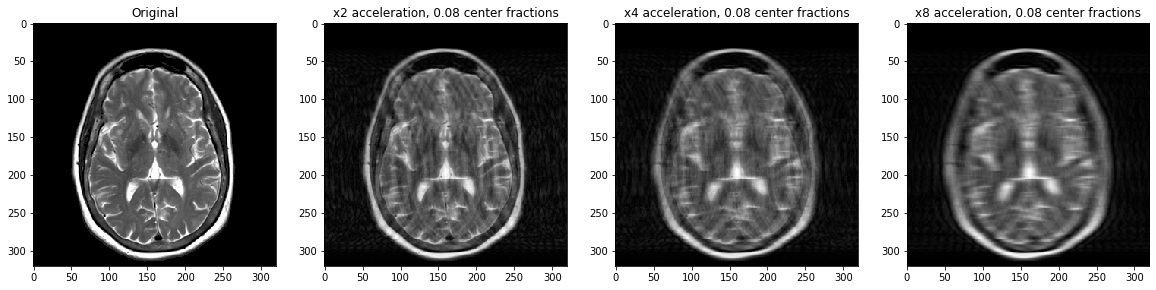

In [28]:
accelerations = [2, 4, 8]
center_fractions = [0.04, 0.08]

i = np.random.randint(0, len(os.listdir(PATH_TO_DATA)))

sampled_slices = []

for center_frac in center_fractions:
    fig, axis = plt.subplots(1, len(accelerations)+1, figsize=(20, 9))

    for j, acceleration in enumerate(accelerations, 1):
        train_loader = MRIDataSampler(PATH_TO_DATA, center_frac, acceleration, 
                                     seed=RANDOM_STATE, threshold=1e-5)

        name, slice, slice_sampled = train_loader.__getitem__(i)
        sampled_slices.append(slice_sampled)

        axis[j].imshow(slice_sampled[0], cmap='gray', vmin=0, vmax=1)
        axis[j].set_title(f'x{acceleration} acceleration, {center_frac} center fractions', fontsize=12)

    axis[0].imshow(slice[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title('Original', fontsize=12)

    plt.show()

In [29]:
for a, sampled_slice in zip(accelerations, sampled_slices):
    print(f'X{a} acceleration:')
    compare_imgs(slice, sampled_slice)

    print()

X2 acceleration:
	MAE	PSNR	SSIM
score	0.067	20.321	0.536

X4 acceleration:
	MAE	PSNR	SSIM
score	0.079	18.110	0.464

X8 acceleration:
	MAE	PSNR	SSIM
score	0.082	17.226	0.445



## Train test split

In [32]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_TEST = 'data/ax_t2_single_source_test'

os.makedirs(PATH_TO_SOURCE_TRAIN, exist_ok=True)
os.makedirs(PATH_TO_SOURCE_TEST, exist_ok=True)

In [33]:
samples = [s for s in os.listdir(PATH_TO_DATA) if s.endswith('npy')]

train_samples, test_samples = train_test_split(samples, test_size=0.2, random_state=RANDOM_STATE)

print(len(train_samples), len(test_samples))

58780 14696


In [34]:
for sample in tqdm(test_samples):
    pass
    #shutil.copy(os.path.join(PATH_TO_DATA, sample), os.path.join(PATH_TO_TEST, sample))

for sample in tqdm(train_samples):
    pass
    #shutil.copy(os.path.join(PATH_TO_DATA, sample), os.path.join(PATH_TO_TRAIN, sample))

## Data sampling

In [41]:
acceleration = 2
center_fraction = 0.08
part = 'test'

if part == 'train':
    path_to_sources = PATH_TO_SOURCE_TRAIN
elif part == 'test':
    path_to_sources = PATH_TO_SOURCE_TEST
else:
    raise ValueError()

path_to_save = f'data/ax_t2_single_sampled_x{acceleration}_{part}/'
print(path_to_sources, path_to_save, sep=' -> ')
os.makedirs(path_to_save, exist_ok=True)

for path, _, slice_sampled in tqdm(MRIDataSampler(path_to_sources, center_fraction, 
                                                  acceleration, seed=RANDOM_STATE, threshold=1e-5)):
    name = os.path.split(path)[1]

    with open(os.path.join(path_to_save, name), 'wb') as f:
        np.save(f, slice_sampled)

data/ax_t2_single_source_test -> data/ax_t2_single_sampled_x2_test/
